In [1]:
# Install rdkit
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO
 
 
logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)
 
 
def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """
 
    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )
 
    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)
 
    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return
 
        logger.info("force re-install")
 
    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)
 
    logger.info("python version: {}".format(python_version))
 
    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)
 
    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')
 
    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')
 
    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python==3.7.3",
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")
 
    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))
 
 
if __name__ == "__main__":
    # install()
    pass

In [2]:
import torch

# def format_pytorch_version(version):
#   return version.split('+')[0]

# TORCH_version = torch.__version__
# TORCH = format_pytorch_version(TORCH_version)

# def format_cuda_version(version):
#   return 'cu' + version.replace('.', '')

# CUDA_version = torch.version.cuda
# CUDA = format_cuda_version(CUDA_version)

# !pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-cluster -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
# !pip install torch-geometric

c:\Users\Legion\.conda\envs\graph\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import warnings
warnings.filterwarnings("ignore")

import rdkit
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

import torch, os
import torch_geometric
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.utils.convert import to_networkx
from torch_geometric.nn import GCNConv, TopKPooling, global_mean_pool
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from itertools import combinations
from matplotlib import pyplot as plt

In [4]:
working_dir = 'data/bench-mark/'
collection = 'MoleculeNet'
dataset = 'ESOL'

data_dir = os.path.join(working_dir, collection)

## Dataset

**ESOL is a small dataset consisting of water solubility data for 1128 compounds. The dataset has been used to train models that estimate solubility directly from chemical structures (as encoded in SMILES strings). Note that these structures don’t include 3D coordinates, since solubility is a property of a molecule and not of its particular conformers.**

In [5]:
data = MoleculeNet(root=data_dir, name=dataset)

print("Dataset type: ", type(data))
print("Dataset features: ", data.num_features)
print("Dataset target: ", data.num_classes)
print("Dataset length: ", data.len)
print("Dataset sample: ", data[0])
print("Sample  nodes: ", data[0].num_nodes)
print("Sample  edges: ", data[0].num_edges)


data0 = data[0]  # Get the first graph object.
print('================= Analyze Single Molecule ===============================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data0.num_nodes}')
print(f'Number of edges: {data0.num_edges}')
print(f'Average node degree: {data0.num_edges / data0.num_nodes:.2f}')
print(f'Has isolated nodes: {data0.has_isolated_nodes()}')
print(f'Has self-loops: {data0.has_self_loops()}')
print(f'Is undirected: {data0.is_undirected()}')

Dataset type:  <class 'torch_geometric.datasets.molecule_net.MoleculeNet'>
Dataset features:  9
Dataset target:  734
Dataset length:  <bound method InMemoryDataset.len of ESOL(1128)>
Dataset sample:  Data(x=[32, 9], edge_index=[2, 68], edge_attr=[68, 3], y=[1, 1], smiles='OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O ')
Sample  nodes:  32
Sample  edges:  68
================= Analyze Single Molecule ===============================
Number of nodes: 32
Number of edges: 68
Average node degree: 2.12
Has isolated nodes: False
Has self-loops: False
Is undirected: True


### Let's Analyze a Single Molecule Graph

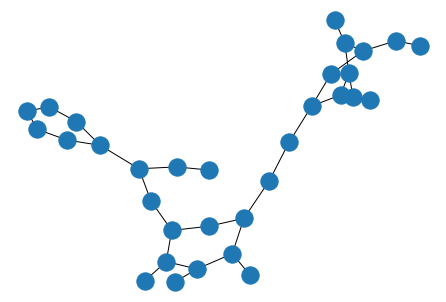

In [6]:
graph0 = to_networkx(data0, to_undirected=True)
nx.draw(graph0)

In [7]:

smile0 = data0["smiles"]
smile0

'OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '

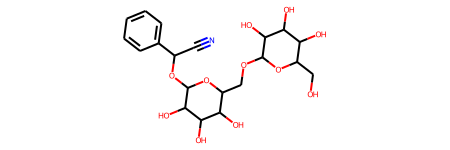

In [8]:
molecule0 = Chem.MolFromSmiles(smile0)
molecule0

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_dim = 64):
        # Init parent
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # GCN layers (Message Passing Layers)
        self.initial_conv = GCNConv(data.num_features, hidden_dim)
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Output layer
        self.out = Linear(hidden_dim*2, 1)

    def forward(self, x, edge_index, batch_index):
        # First Conv layer
        hidden = self.initial_conv(x, edge_index)
        hidden = F.tanh(hidden)

        # Other Conv layers
        hidden = self.conv1(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv2(hidden, edge_index)
        hidden = F.tanh(hidden)
        hidden = self.conv3(hidden, edge_index)
        hidden = F.tanh(hidden)
          
        # Global Pooling (stack different aggregations)
        hidden = torch.cat([gmp(hidden, batch_index), 
                            gap(hidden, batch_index)], dim=1)

        '''
        The reason we pass batch_index to the pooling functions is that we want to
        select the correct nodes for each graph in the batch. 
        '''
        
        # Apply a final (linear) classifier.
        out = self.out(hidden)

        return out, hidden

In [10]:
model = GCN()
model

GCN(
  (initial_conv): GCNConv(9, 64)
  (conv1): GCNConv(64, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (out): Linear(in_features=128, out_features=1, bias=True)
)

In [11]:
class MoleculeClassification(object):
    def __init__(self):
        self.loss_fn = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(
                                    model.parameters(), 
                                    lr = 0.0007
                                    )  

        # Use GPU for training
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        if torch.cuda.is_available():
            print("Using GPU")
        else:
            print("Using CPU")
            
        self.model = model.to(self.device)
        self.TorchDataLoader()

    def TorchDataLoader(self, batch_size = 16, train_split = 0.8):
        data_size = len(data)
        self.loader = DataLoader(
                            data[:int(data_size * train_split)], 
                            batch_size=batch_size, 
                            shuffle=True
                            )

        self.test_loader = DataLoader(
                            data[int(data_size * (1 - train_split)):], 
                            batch_size=batch_size, 
                            shuffle=True
                            )

    def train_epoch(self):
        self.model.train()
        for batch in self.loader:
            batch.to(self.device)  
            self.optimizer.zero_grad() 
            pred, embedding = self.model(batch.x.float(), batch.edge_index, batch.batch) 
            loss = self.loss_fn(pred, batch.y)     
            loss.backward()  
            self.optimizer.step()   
        return loss, embedding

    def train(self, epoches = 2000):
        print("Starting training...")
        losses = []
        for epoch in range(epoches):
            loss, h = self.train_epoch()
            loss = loss.item()
            losses.append(loss)
            if epoch % 100 == 0:
              print(f"Epoch {epoch} | Train Loss {loss}")
        self.plot_loss(losses)

    def plot_loss(self, losses):
        losses_float = [loss for loss in losses] 
        loss_indices = [i for i,l in enumerate(losses_float)] 
        plt = sns.lineplot(loss_indices, losses_float)

    def predictions(self):
        # Analyze the results for one batch
        test_batch = next(iter(self.test_loader))
        with torch.no_grad():
            test_batch.to(self.device)
            pred, embed = self.model(test_batch.x.float(), test_batch.edge_index, test_batch.batch) 
            df = pd.DataFrame()
            df["y_real"] = test_batch.y.tolist()
            df["y_pred"] = pred.tolist()
        df["y_real"] = df["y_real"].apply(lambda row: row[0])
        df["y_pred"] = df["y_pred"].apply(lambda row: row[0])
        return df

Using GPU
Starting training...
Epoch 0 | Train Loss 8.272598266601562
Epoch 100 | Train Loss 0.9255666732788086
Epoch 200 | Train Loss 0.2737504243850708
Epoch 300 | Train Loss 0.25680217146873474
Epoch 400 | Train Loss 0.08341541141271591
Epoch 500 | Train Loss 0.08088754117488861
Epoch 600 | Train Loss 0.27189865708351135
Epoch 700 | Train Loss 0.04874124377965927
Epoch 800 | Train Loss 0.057118549942970276
Epoch 900 | Train Loss 0.0076979356817901134
Epoch 1000 | Train Loss 0.040043920278549194
Epoch 1100 | Train Loss 0.017363794147968292
Epoch 1200 | Train Loss 0.08132185786962509
Epoch 1300 | Train Loss 0.02288127690553665
Epoch 1400 | Train Loss 0.011043824255466461
Epoch 1500 | Train Loss 0.005278063006699085
Epoch 1600 | Train Loss 0.06076434999704361
Epoch 1700 | Train Loss 0.0031152653973549604
Epoch 1800 | Train Loss 0.04859023541212082
Epoch 1900 | Train Loss 0.004716080613434315


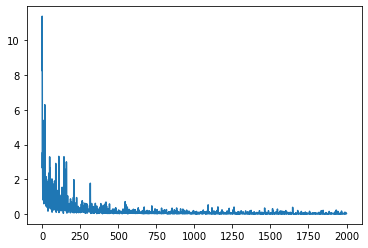

In [12]:
classifier = MoleculeClassification()
classifier.train()

In [13]:
df_batch = classifier.predictions()
df_batch

,y_real,y_pred
0,-0.460,-0.499920
1,-2.300,-2.243564
2,-1.990,-1.998772
3,-2.590,-2.666678
4,-4.500,-4.345428
5,-0.620,-0.638031
6,-2.593,-2.467275
7,-5.850,-5.253547
8,-3.800,-3.832786
9,0.790,0.092433


[(-7.0, 2.0)]

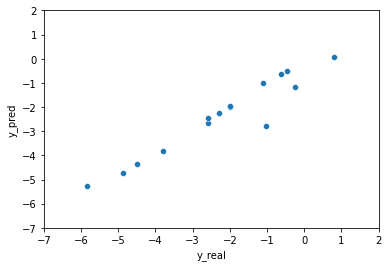

In [14]:
plt = sns.scatterplot(data=df_batch, x="y_real", y="y_pred")
plt.set(xlim=(-7, 2))
plt.set(ylim=(-7, 2))

# Why Global Graph Pooling ??
  
Graphs Have Different Sizes (Different Number of Nodes & Edges). Since we doing  **Graph Level** Prediction we need perform this representative learning networks for dynamic sizes of graphs with fixed size output. So we use **Global Pooling Mechanism** to squeeze any number of nodes (differnet sizes) into one fixed representation. Here we use MEAN & MAX global pooling techniques in that case

